[![git](ATLASOD.gif)](http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html)

<CENTER><h1>Estudio de la Significancia Esperada, $Z_{0}$, para diferentes cortes del Bosón de Higgs en el Canal de Decaimiento $H \rightarrow WW^{*}\rightarrow e\nu\mu\nu$     a      $\sqrt{s}=13TeV$</h1></CENTER>

---------------------
Necesitamos incluir algunas librerias de C++ y ROOT

In [1]:
#include <iostream>
#include <vector>
#include <stdio.h>
#include "TFile.h"
#include "TString.h"
#include "TChain.h"
#include <TTreeReader.h>
#include <TTreeReaderValue.h>
#include <TTreeReaderArray.h>
using namespace std;

<p>Introducimos dos funciones creadas para el proposito de este análisis</p>

In [2]:
#include "array_sample.C"
#include "main_HWWAnalysis.C"

------------------------
<p>Creamos el TChain y TTreeReader</p>

In [3]:
TChain *fchain = new TChain("mini");
TTreeReader fReader;

<p> Definimos las variables para acceder a los datos</p>

In [4]:
TTreeReaderValue<Bool_t> trigE = {fReader, "trigE"};
TTreeReaderValue<Bool_t> trigM = {fReader, "trigM"};
TTreeReaderValue<UInt_t> lep_n = {fReader, "lep_n"};
TTreeReaderArray<float> lep_pt = {fReader, "lep_pt"};
TTreeReaderArray<float> lep_eta = {fReader, "lep_eta"};
TTreeReaderArray<float> lep_phi = {fReader, "lep_phi"};
TTreeReaderArray<float> lep_E = {fReader, "lep_E"};
TTreeReaderArray<float> lep_z0 = {fReader, "lep_z0"};
TTreeReaderArray<int> lep_charge = {fReader, "lep_charge"};
TTreeReaderArray<unsigned int> lep_type = {fReader, "lep_type"};
TTreeReaderValue<vector<bool>> lep_isTightID = {fReader, "lep_isTightID"};
TTreeReaderArray<float> lep_ptcone30 = {fReader, "lep_ptcone30"};
TTreeReaderArray<float> lep_etcone20 = {fReader, "lep_etcone20"};
TTreeReaderArray<float> lep_trackd0pvunbiased = {fReader, "lep_trackd0pvunbiased"};
TTreeReaderArray<float> lep_tracksigd0pvunbiased = {fReader, "lep_tracksigd0pvunbiased"};
TTreeReaderValue<Float_t> met_et = {fReader, "met_et"};
TTreeReaderValue<Float_t> met_phi = {fReader, "met_phi"};
TTreeReaderValue<UInt_t> jet_n = {fReader, "jet_n"};
TTreeReaderArray<float> jet_pt = {fReader, "jet_pt"};
TTreeReaderArray<float> jet_eta = {fReader, "jet_eta"};
TTreeReaderArray<float> jet_phi = {fReader, "jet_phi"};
TTreeReaderArray<float> jet_E = {fReader, "jet_E"};
TTreeReaderArray<float> jet_jvt = {fReader, "jet_jvt"};
TTreeReaderArray<float> jet_MV2c10 = {fReader, "jet_MV2c10"};
TTreeReaderValue<Int_t> runNumber = {fReader, "runNumber"};
TTreeReaderValue<Int_t> eventNumber = {fReader, "eventNumber"};
TTreeReaderValue<Int_t> channelNumber = {fReader, "channelNumber"};

----------------------
<p>Creamos dos histogramas</p>

In [5]:
TH1F *mt_signal = new TH1F("mt_signal", "Dilepton System Transverse Mass; m_{T} [GeV];Events", 15, 50, 200);
TH1F *mt_bkg = new TH1F("mt_bkg","Dilepton System Transverse Mass; m_{T} [GeV];Events", 15, 50, 200);

mt_signal->SetMarkerSize(2);         mt_bkg->SetMarkerSize(2);
mt_signal->SetFillColor(kBlue-5);   mt_bkg->SetFillColor(kRed-5);
mt_signal->SetLineColor(kBlue);      mt_bkg->SetLineColor(kRed);

-----------------
<p><b>Opción a correr</b></p>

<p>0 = Una señal (ggH125) + Background </p>
<p>1 = Una señal (VBFH125) +Backgroun</p>
<p>2 = Dos señal (ggH125+VBFH125) + Background</p>

In [6]:
int option = 0;
cout<<"option: "<<option<<endl;

option: 0


In [7]:
vector<string> sample;
array_samples(sample,option);

---------------------
<h3>Analysis</h3>

In [8]:
int s = 0; //signal
int b = 0; //Background
float Z;
for (unsigned int i=0;i<sample.size();i++){ 
    
    fchain = main_HWWAnalysis(sample[i]);
    fReader.SetTree(fchain);
    Long64_t nentries = fReader.GetEntries(1);
    cout<< "Muestra a Analizar: "<< sample[i] << " # Events: " <<nentries << endl;
    
    while (fReader.Next()){
        
        //Preselection cut for electron/muon trigger
        if (*trigE || *trigM){
            
            // Preselection of good Leptons
            int goodlep_index[2];
            int goodlep_n = 0;
            int lep_index = 0;
            
            for (unsigned int j=0; j<*lep_n; j++){
                
                TLorentzVector leptemp;
                leptemp.SetPtEtaPhiE(lep_pt[j]/1000., lep_eta[j], lep_phi[j], lep_E[j]/1000.);
                
                // Lepton is Tight----boolean indicating whether lepton satisfies tight ID reconstruction criteria
                if (lep_isTightID->at(j)){
                    
                    // standard lepton isolation requirement => strict isolation
                    if ((lep_pt[j]>15000.) && (lep_ptcone30[j]/lep_pt[j]<0.1) && (lep_etcone20[j]/lep_pt[j]<0.1)){
                       
                        // electron selection
                        if ((lep_type[j]==11) && (TMath::Abs(lep_eta[j])<2.47) && ((TMath::Abs(lep_eta[j])<1.37) || (TMath::Abs(lep_eta[j])>1.52))){
                            if ((TMath::Abs(lep_trackd0pvunbiased[j])/lep_tracksigd0pvunbiased[j]<5) && (TMath::Abs(lep_z0[j]*TMath::Sin(leptemp.Theta()))<0.5)){
                                goodlep_n = goodlep_n + 1;
                                goodlep_index[lep_index] = j;
                                lep_index++;
                            }
                        }
                        // muon selection
                        if ((lep_type[j]==13) && (TMath::Abs(lep_eta[j])<2.5)){
                            if ((TMath::Abs(lep_trackd0pvunbiased[j])/lep_tracksigd0pvunbiased[j]<3) && (TMath::Abs(lep_z0[j]*TMath::Sin(leptemp.Theta()))<0.5)){
                                goodlep_n = goodlep_n + 1;
                                goodlep_index[lep_index] = j;
                                lep_index++;
                            }
                        }
                    }
                }//End_Tight
                
            }
            
            //Exactly two good leptons, leading lepton with pT > 22 GeV and the subleading lepton with pT > 15 GeV
            if (goodlep_n==2){
                       
                int goodlep1_index = goodlep_index[0];
                int goodlep2_index = goodlep_index[1];
                
                if (lep_pt[goodlep1_index]>22000.){
                    
                    //two different-flavour opposite-sign leptons
                    if (lep_type[goodlep1_index] != lep_type[goodlep2_index]){
                        if (lep_charge[goodlep1_index]*lep_charge[goodlep2_index]<0){
                            
                            //TLorentzVector Definitions
                            TLorentzVector Lepton_1  = TLorentzVector();
                            TLorentzVector Lepton_2  = TLorentzVector();
                            TLorentzVector      MeT  = TLorentzVector();
  
                            Lepton_1.SetPtEtaPhiE(lep_pt[goodlep1_index]/1000., lep_eta[goodlep1_index], lep_phi[goodlep1_index],lep_E[goodlep1_index]/1000.);
                            Lepton_2.SetPtEtaPhiE(lep_pt[goodlep2_index]/1000., lep_eta[goodlep2_index], lep_phi[goodlep2_index],lep_E[goodlep2_index]/1000.);
                            MeT.SetPtEtaPhiE(*met_et/1000., 0, *met_phi , *met_et/1000.);
                            
                            TLorentzVector Lepton_12 = TLorentzVector();
                            Lepton_12 = Lepton_1 + Lepton_2;
                            
                            float mLL = Lepton_12.Mag(); //The invariant mass of the two leptons

                            float ptLL = Lepton_12.Pt(); //Transverse momentum of the dilepton system
                            
                            Float_t MET = *met_et/1000.; // Missing transverse momentum
                            
                            //Azimuthal angle between the two leptons
                            float dPhi_LL = TMath::Abs(lep_phi[goodlep1_index]-lep_phi[goodlep2_index]);
                            dPhi_LL = dPhi_LL < TMath::Pi() ? dPhi_LL : 2*TMath::Pi() - dPhi_LL;
                            
                            //Azimuthal angle between E_T^miss and the dilepton system
                            float dPhiLLmet = TMath::Abs(Lepton_12.Phi() - MeT.Phi());
                            dPhiLLmet    = dPhiLLmet < TMath::Pi() ? dPhiLLmet : 2*TMath::Pi() - dPhiLLmet;
                            
                            //dilepton transverse mass
                            float mt = sqrt(2*Lepton_12.Pt()*MeT.Et()*(1-cos(Lepton_12.DeltaPhi(MeT))));
                            
                            // Preselection of good jets
                            int goodjet_n = 0;
                            int goodbjet_n = 0;
                            
                            int goodjet_index[*jet_n];
                            int jet_index = 0;
                            
                            int goodbjet_index[*jet_n];
                            int bjet_index = 0;
                            
                            for (unsigned int j=0; j<*jet_n; j++){
                                
                                if ((jet_pt[j]>20000.) && (TMath::Abs(jet_eta[j])<2.5)){
                                    
                                    //JVT cleaning
                                    bool jvt_pass = true;
                                    
                                    if ((jet_pt[j]<60000.) && (TMath::Abs(jet_eta[j])<2.4) && (jet_jvt[j]<0.59)) {jvt_pass=false;}
                                    
                                    if (jvt_pass){
                                        
                                        // cut on 85% WP
                                        if (jet_MV2c10[j] > 0.1758475){
                                            goodbjet_n++;
                                            goodbjet_index[bjet_index] = j;
                                            bjet_index++;
                                        }
                                        
                                        if (jet_pt[j]>30000.){
                                            goodjet_n++;
                                            goodjet_index[jet_index] = j;
                                            jet_index++;
                                        }
                                    }
                                    
                                }
                            }
                            
                            //  remove low mass meson resonances and DY events; ggF regions, at least 1 jet
                            if ( (mLL > 10) && (goodjet_n <= 1) && (MET > 20) ){
                                
                                if (mLL < 55){
                                    
                                    if (ptLL > 30){
                                        
                                        if (dPhi_LL < 1.8){
                                            
                                            if (dPhiLLmet > TMath::Pi()/2){
                                                
                                                if (goodbjet_n ==0){
                                                    
                                                    TString foption = sample[i];
                                                    if (foption.Contains("ggH125") || foption.Contains("VBFH125")){
                                                        s++;
                                                        mt_signal->Fill(mt);
                                                    } else{
                                                        b++;
                                                        mt_bkg->Fill(mt);
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
    
    cout<< "Muestra Analizada: "<< sample[i] << endl;
}

Muestra a Analizar: ggH125_WW2lep # Events: 628685
Muestra Analizada: ggH125_WW2lep
Muestra a Analizar: ZqqZll # Events: 1403146
Muestra Analizada: ZqqZll
Muestra a Analizar: WqqZll # Events: 1316619
Muestra Analizada: WqqZll
Muestra a Analizar: WpqqWmlv # Events: 13375
Muestra Analizada: WpqqWmlv
Muestra a Analizar: WplvWmqq # Events: 14245
Muestra Analizada: WplvWmqq
Muestra a Analizar: WlvZqq # Events: 28199
Muestra Analizada: WlvZqq
Muestra a Analizar: llll # Events: 4266124
Muestra Analizada: llll
Muestra a Analizar: lllv # Events: 3791795
Muestra Analizada: lllv
Muestra a Analizar: llvv # Events: 3409043
Muestra Analizada: llvv
Muestra a Analizar: lvvv # Events: 11789
Muestra Analizada: lvvv


In [ ]:
//Z=sqrt(2*((s+b)*LogE(1+(s/b))-s));

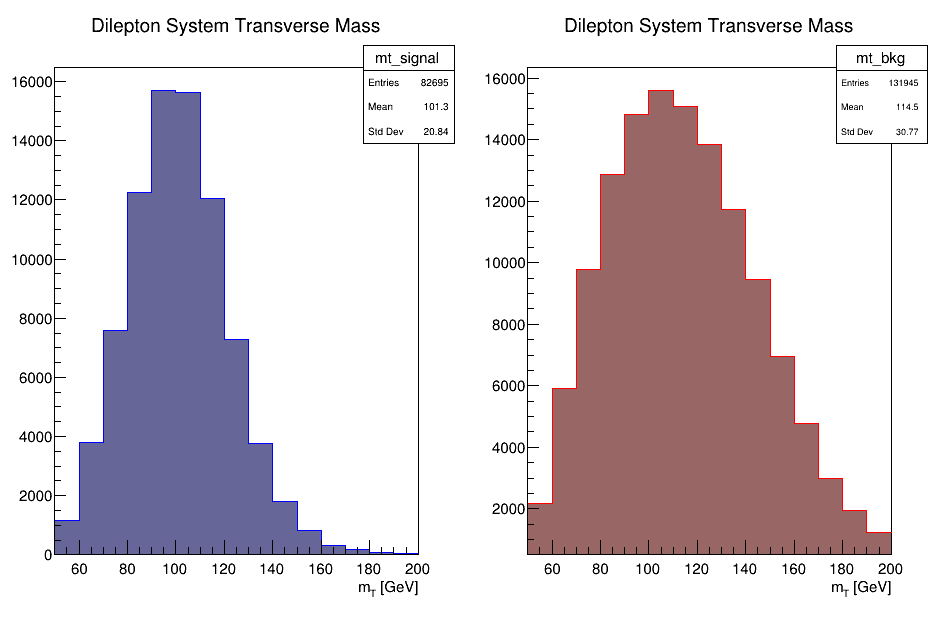

In [9]:
TCanvas *c = new TCanvas("c","c",10,10,950,650);
    //TText tz; tz.SetTextFont(42); tz.SetTextAlign(21);
    c->Divide(2,1);
    c->cd(1); mt_signal->Draw();
    c->cd(2); mt_bkg->Draw();
c->Draw();